In [83]:
import sys
sys.path.append('../')

from quantumsim import *
import pennylane as qml
from pennylane import numpy as np
import dask

def molecular_energies(symbols, coordinates, basis_set, charge=0):
    multiplicity = 1
    # Generate the molecular Hamiltonian
    hamiltonian = qml.qchem.molecular_hamiltonian(
        symbols = symbols,
        coordinates = coordinates,
        basis=basis_set,
        charge=charge,
        mult=multiplicity
    )[0]

    # Obtain the matrix representation of the Hamiltonian
    ee = qml.eigvals(hamiltonian)
    return np.sort(ee)

In [58]:
part = qml.data.load('qspin', sysname='FermiHubbard', periodicity='open', lattice='chain', layout='1x4' )

In [77]:
part[0].hamiltonians[0].parameters

[(0.5+0j),
 (0.5+0j),
 (0.5+0j),
 (0.5+0j),
 (0.5+0j),
 (0.5+0j),
 (0.5+0j),
 (0.5+0j),
 (0.5+0j),
 (0.5+0j),
 (0.5+0j),
 (0.5+0j),
 0j,
 0j,
 0j,
 0j]

In [90]:
import pennylane as qml
from pennylane import numpy as np
import dask

symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614], requires_grad=True)
hamil, qubits = qml.qchem.molecular_hamiltonian( symbols= symbols, coordinates= coordinates, charge=0)
coeff, terms = hamil.terms()
terms, coeff = qml.pauli.group_observables(observables=terms, coefficients=coeff, grouping_type='qwc', method='rlf')

dev = qml.device('default.qubit', wires=4)
begin_state = qml.qchem.hf_state(electrons=2, orbitals=qubits)
singles, doubles = qml.qchem.excitations(2, qubits)
singles, doubles = qml.qchem.excitations_to_wires(singles, doubles)

def circuit2(theta, index):
    qml.UCCSD(theta, range(qubits), singles, doubles, begin_state)
    return [qml.expval(u) for u in terms[index]]


node = qml.QNode(circuit2, dev)

def process_group(theta, i):
    result_probs = node(theta=theta, index=i)
    return np.sum( coeff[i]*np.array(result_probs) )

def cost_function(theta):
    results = []
    for i in range(len(terms)):
        results.append( dask.delayed(process_group)(theta, i) )
    num_workers = 4
    result = dask.compute(*results, scheduler="processes", num_workers=num_workers)
    return np.sum( result )

number = len(singles) + len(doubles)
theta = np.random.random( size=number )*(np.pi/180.0)
#theta_optimizer = qml.GradientDescentOptimizer(stepsize=0.1)
theta_optimizer = qml.AdamOptimizer(stepsize=0.001)
energy = [cost_function(theta)]
theta_evol = [theta]
for _ in range(80):
    theta.requires_grad = True
    theta = theta_optimizer.step(cost_function, theta)
    energy.append(cost_function(theta))
    theta_evol.append(theta)
    prev_energy = energy[len(energy)-2]
    print(energy[-1])
    conv = np.abs(energy[-1] - prev_energy)
    if conv <= 1e-6:
        break

-1.1204612294469936
-1.120630144881895
-1.1207969636854789
-1.120961693773231
-1.1211243903137778
-1.1212851780153585
-1.12144425643313
-1.1216018605304716
-1.121758187936007
-1.1219133516565811
-1.122067384363202
-1.122220266808877
-1.1223719534952004
-1.1225223889377645
-1.1226715167524373
-1.122819284361282
-1.1229656450145087
-1.123110558118143
-1.1232539885782384
-1.1233959057227791
-1.1235362821930253
-1.1236750930140653
-1.123812314909946
-1.1239479258447127
-1.1240819047380182
-1.1242142313014667
-1.124344885951932
-1.1244738497706768
-1.1246011044877564
-1.1247266324790552
-1.1248504167684736
-1.1249724410311441
-1.1250926895954685
-1.1252111474430229
-1.12532780020599
-1.1254426341620873
-1.1255556362272519
-1.1256667939462661
-1.1257760954816802
-1.1258835296012748
-1.1259890856643238
-1.1260927536069125
-1.126194523926495
-1.126294387665904
-1.1263923363969313
-1.1264883622036614
-1.1265824576656573
-1.126674615841089
-1.1267648302499043
-1.1268530948571722
-1.1269394040565

/Users/jnorambu/Documents/vqesimulation/venv/lib/python3.9/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


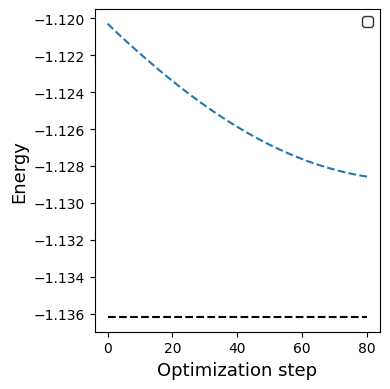

In [91]:
import matplotlib.pyplot as plt
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set="sto-3g")

fig, ax = plt.subplots(1, 1, figsize=(4,4),)
ax.set_xlabel("Optimization step", fontsize=13)
ax.set_ylabel("Energy", fontsize=13)

ax.plot([j for j in range(len(energy))], energy, ls="dashed")
ax.plot([j for j in range( len(energy) ) ], [ee[0] for j in range( len(energy) )], color="black", ls="dashed")

ax.legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

In [10]:
import pennylane as qml
from pennylane import numpy as np
import dask

symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614], requires_grad=True)
hamil, qubits = qchem.molecular_hamiltonian( symbols= symbols, coordinates= coordinates, charge=0)
coeff, terms = hamil.terms()
terms, coeff = qml.pauli.group_observables(observables=terms, coefficients=coeff, grouping_type='qwc', method='rlf')

dev = qml.device('default.qubit', wires=4)
begin_state = qml.qchem.hf_state(electrons=2, orbitals=qubits)
singles, doubles = qml.qchem.excitations(2, qubits)
singles, doubles = qml.qchem.excitations_to_wires(singles, doubles)


def circuit2(theta, index):
    qml.UCCSD(theta, range(qubits), singles, doubles, begin_state)
    return [qml.expval(u) for u in terms[index]]

node = qml.QNode(circuit2, dev)

def process_group(theta, i):
    result_probs = node(theta=theta, index=i)
    return np.sum( coeff[i]*np.array(result_probs) )

def cost_function(theta):
    results = []
    for i in range(len(terms)):
        results.append( process_group(theta, i) )
    return np.sum( results )


number = len(singles) + len(doubles)
theta = np.clip(np.random.random( size=number )*(np.pi/180.0), 0, 1e-5)


theta_optimizer = qml.GradientDescentOptimizer(stepsize=0.3)
energy = [cost_function(theta)]
theta_evol = [theta]
for _ in range(100):
    theta.requires_grad = True
    theta = theta_optimizer.step(cost_function, theta)
    energy.append(cost_function(theta))
    theta_evol.append(theta)
    prev_energy = energy[len(energy)-2]
    print(energy[-1])
    conv = np.abs(energy[-1] - prev_energy)
    if conv <= 1e-6:
        break

-1.125745451549811
-1.1304166481171758
-1.1330038506741504
-1.13443310695377
-1.1352215461403654
-1.1356561393802964
-1.1358955858044013
-1.1360274811179079
-1.1361001239663129
-1.1361401299255867
-1.1361621611718928
-1.1361742934912975
-1.1361809745196392
-1.1361846536051277
-1.1361866795836648
-1.1361877952361046
-1.1361884095955104


In [2]:
import numpy as np
from tenpy.models.model import Model
from tenpy.models.site import SpinHalfSite
from tenpy.tools.params import asConfig
from tenpy.networks.site import boson_site, spinful_fermion_site
from tenpy.networks.mps import MPS
from tenpy.algorithms import dmrg

class FermiHubbardModel(Model):
    def __init__(self, L, t, U, bc_MPS='infinite'):
        self.L = L  # Number of lattice sites
        self.t = t  # Hopping amplitude
        self.U = U  # On-site interaction strength
        self.bc_MPS = bc_MPS  # Boundary condition for the MPS algorithm

        self._init_sites()
        self._init_terms()

        super().__init__(self.sites, self.terms)

    def _init_sites(self):
        self.site = spinful_fermion_site()
        self.sites = [self.site] * self.L

    def _init_terms(self):
        self.terms = []

        for i in range(self.L - 1):
            self.terms.append((-self.t, i, (i + 1) % self.L, 'c', 'c_dag'))
            self.terms.append((-self.t, i, (i + 1) % self.L, 'c_dag', 'c'))

        for i in range(self.L):
            self.terms.append((self.U, i, i, 'n', 'n'))

if __name__ == '__main__':
    L = 6  # Number of lattice sites
    t = 1.0  # Hopping amplitude
    U = 4.0  # On-site interaction strength

    # Construct the Fermi-Hubbard model with open boundary conditions
    model_open_bc = FermiHubbardModel(L, t, U, bc_MPS='finite')

    # Construct the Fermi-Hubbard model with periodic (closed) boundary conditions
    model_periodic_bc = FermiHubbardModel(L, t, U, bc_MPS='infinite')

    # You can now use these models with DMRG or other algorithms to calculate properties.
    # For example, you can create MPS states and perform DMRG calculations.


ModuleNotFoundError: No module named 'tenpy.models'